In [1]:
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow
import tqdm
from keras.callbacks import TensorBoard
from tensorflow.keras.metrics import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import src.data.Dataset as dt

In [2]:
required_paths = ["/ai4eutils", "/CameraTraps", "/yolov5"]
python_path = os.environ.get("PYTHONPATH", "")
root_path = os.getcwd()

for path in required_paths:
    if not any(p.endswith(path) for p in python_path.split(":")):
        python_path += f":{root_path}/data/external{path}"

os.environ["PYTHONPATH"] = python_path

!echo "PYTHONPATH: $PYTHONPATH"

PYTHONPATH: :/Users/carlos/WORKSPACE/MegaClassifier/data/external/ai4eutils:/Users/carlos/WORKSPACE/MegaClassifier/data/external/CameraTraps:/Users/carlos/WORKSPACE/MegaClassifier/data/external/yolov5


In [3]:
DATASET_NAME = "preprocessed_megadetector"
DATASET_PATH = os.path.abspath("./data/processed")
IMAGES_DATASET_PATH = os.path.join(DATASET_PATH, DATASET_NAME)

ORIGINAL_IMAGES_DATASET = os.path.abspath("./data/raw/emptyNonEmptyDataset_ETL")
FIT_IMAGES_DATASET = os.path.abspath(
    "./data/interim/fit_images/emptyNonEmptyDataset_ETL"
)

SAMPLES_CSV = os.path.abspath(
    "data/raw/emptyNonEmptyDataset_ETL/28560Images_detection.csv"
)


print(f"IMAGES_DATASET_PATH:     {IMAGES_DATASET_PATH}")
print(f"ORIGINAL_IMAGES_DATASET: {ORIGINAL_IMAGES_DATASET}")
print(f"FIT_IMAGES_DATASET:      {FIT_IMAGES_DATASET}")
print(f"SAMPLES_CSV:             {SAMPLES_CSV}")

IMAGES_DATASET_PATH:     /Users/carlos/WORKSPACE/MegaClassifier/data/processed/preprocessed_megadetector
ORIGINAL_IMAGES_DATASET: /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL
FIT_IMAGES_DATASET:      /Users/carlos/WORKSPACE/MegaClassifier/data/interim/fit_images/emptyNonEmptyDataset_ETL
SAMPLES_CSV:             /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28560Images_detection.csv


In [4]:
samples_dataframe = dt.load_from_csv(SAMPLES_CSV)
samples_dataframe.head()

The file /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28560Images_detection.csv has been successfully opened.


,file_name,label,binary_label,detector_label,subset
0,cervidae/cervidredorfallowdeer_zoo_1_4/20_2020...,cervidae,1,1,train
1,leporido/conejo_wellingtoncameratraps_ss/19081...,leporido,1,1,train
2,vacia/empty_snapshotmountainzebra/mtz_s1_d07_r...,vacia,0,1,train
3,vacia/noanimal_zoo_5_6_7_9/37_20210319_943_.jpg,vacia,0,1,test
4,vacia/empty_islandconservationcameratraps/domi...,vacia,0,1,train


In [5]:
for index in tqdm.tqdm(samples_dataframe.index):
    file_name = samples_dataframe.loc[index, "file_name"]
    megadetector_label = samples_dataframe.loc[index, "detector_label"]

    if megadetector_label == 1:
        samples_dataframe.loc[index, "file_name_new"] = os.path.join(
            FIT_IMAGES_DATASET, file_name
        )
    else:
        samples_dataframe.loc[index, "file_name_new"] = os.path.join(
            ORIGINAL_IMAGES_DATASET, file_name
        )

samples_dataframe["binary_label"] = samples_dataframe["binary_label"].astype("str")

100%|██████████| 28560/28560 [00:01<00:00, 22141.85it/s]


In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25
VERSION = 1.0

train_datagen = ImageDataGenerator(
    preprocessing_function=tensorflow.keras.applications.mobilenet_v2.preprocess_input
)
train_images = train_datagen.flow_from_dataframe(
    dataframe=samples_dataframe,
    x_col="file_name_new",
    y_col="binary_label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    seed=42,
)

Found 28560 validated image filenames belonging to 2 classes.


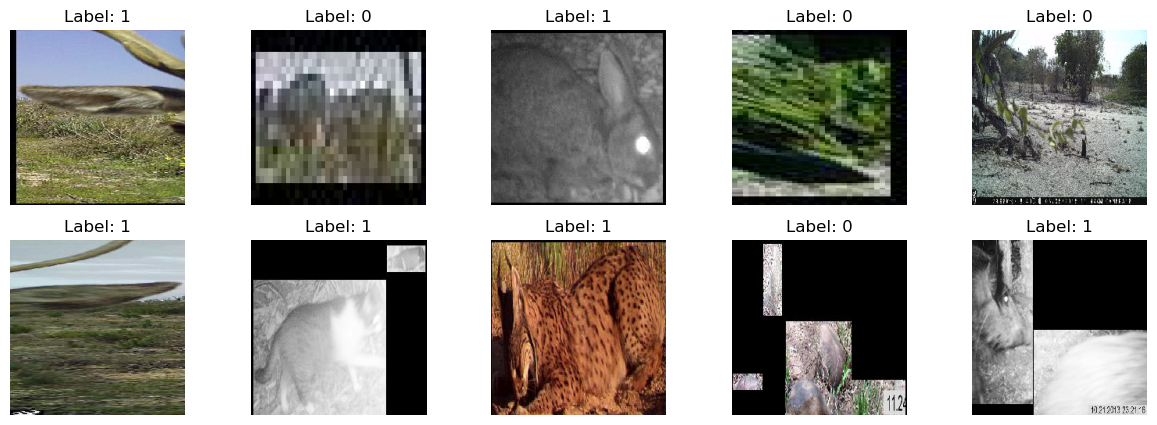

In [7]:
def show_random_images_from_generator(generator, title):
    images, labels = next(generator)
    # Asegúrate de que las imágenes estén en el rango [0, 1] para visualizarlas correctamente
    images = (
        images + 1
    ) * 127.5  # Si las imágenes están en el rango [-1, 1], esto las lleva a [0, 255]
    images = np.clip(images, 0, 255)  # Asegúrate de que no haya valores fuera de rango

    plt.figure(figsize=(15, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(
            images[i].astype("uint8")
        )  # Convierte a enteros de 8 bits para la visualización
        plt.title(f"Label: {int(labels[i])}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()


show_random_images_from_generator(train_images, "")

In [8]:
for _, row in tqdm.tqdm(samples_dataframe.iterrows()):
    original_file = row["file_name_new"]
    new_dataset = os.path.join(IMAGES_DATASET_PATH, row["file_name"])

    os.makedirs(os.path.dirname(new_dataset), exist_ok=True)

    try:
        shutil.copyfile(original_file, new_dataset)
    except FileNotFoundError:
        print(f"File not found: {original_file}")

28560it [00:11, 2548.32it/s]
